In [1]:
from datetime import date

import pandas as pd
import numpy as np

import xarray as xr
import datetime
import matplotlib.pyplot as plt

# Import the function to get connect to the db
from snowexsql.db import get_db
# Import for database tables
from snowexsql.data import LayerData, PointData, ImageData, SiteData
# Import the function to investigate a table
from snowexsql.db import get_table_attributes
# Import a useful function to format that data into a dataframe
from snowexsql.conversions import query_to_geopandas

Connect to SnowEx database

In [2]:
# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

Connect to LayerData table

In [3]:
# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(LayerData)

# Print out the results nicely
#print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

Make a query of temperature profiles

In [4]:
# Pick a dataset
dataset = 'temperature'
# Pick a date
#collection_date = date(2020, 2, 8)

# Make the query
qry = session.query(LayerData).filter(LayerData.type == 'temperature')#.filter(LayerData.date == collection_date)
# Limit it to a couple thousand 
qry = qry.limit(2000)

# Execute the query and convert to geopandas in one handy function
df = query_to_geopandas(qry, engine)

# how many did we retrieve?
print(f'{len(df.index)} records returned!')

1675 records returned!


close the db session

In [5]:
# Close the session to avoid hanging transactions
session.close()

---

Convert geodataframe into an xarray dataset

In [6]:
# Create a datetime column combining date and time
df['datetime'] = [datetime.datetime.combine(row.date, row.time) for _, row in df.iterrows()]

unpack the columns we want from the dataframe

In [7]:
# unpack values from dataframe that we want, make sure to set the datatypes we want
time = df.datetime.values
depth = df.depth.values.astype(np.float64)
northing = df.northing.values.astype(np.float64)
easting = df.easting.values.astype(np.float64)
longitude = df.longitude.values.astype(np.float64)
latitude = df.latitude.values.astype(np.float64)
temperature = df.value.values.astype(np.float64)

Build a dataset from these columns

In [8]:
# build a dataset
ds = xr.Dataset(
    data_vars=dict(
        temperature=(["time"], temperature)
    ),
    coords=dict(
        #lon=(["time"], longitude),
        #lat=(["time"], latitude),
        easting=(["time"], easting),
        northing=(["time"],northing),
        depth=(["time"], depth),
        time=(["time"], time),
    ),
    attrs=dict(description="snow pit temperature dataset"),
)

Try making some plots

Text(0.5, 1.0, 'Snow layer temperature with depth over time')

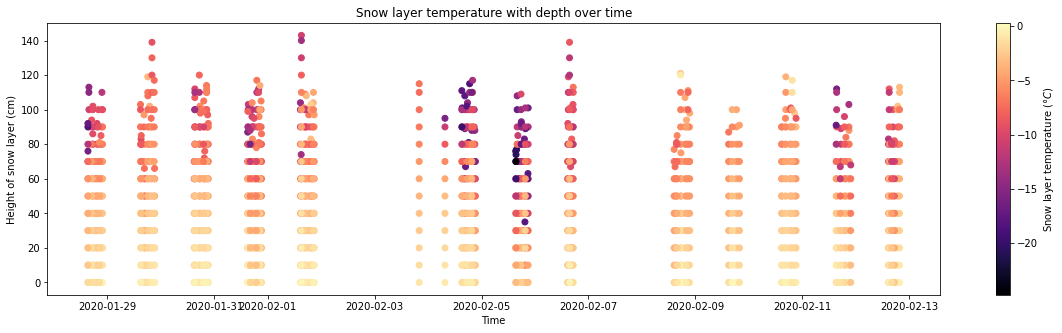

In [9]:
plt.figure(figsize=(20,5))

plt.scatter(x=ds.time, y=ds.depth, c=ds.temperature, cmap='magma')

plt.colorbar(label='Snow layer temperature ($\degree C$)')

plt.xlabel('Time')
plt.ylabel('Height of snow layer (cm)')

plt.title('Snow layer temperature with depth over time')

Text(0.5, 1.0, 'Snow layer temperatures\n(point size proportional to depth)')

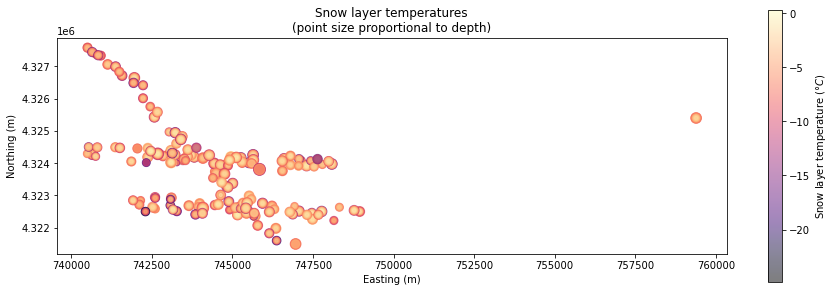

In [10]:
plt.figure(figsize=(15,5))

plt.gca().set_aspect('equal')

plt.scatter(x=ds.easting,y=ds.northing, c=ds.temperature, s=ds.depth, alpha=0.5, cmap='magma')

plt.colorbar(label='Snow layer temperature ($\degree C$)');


plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.title('Snow layer temperatures\n(point size proportional to depth)')